# Reproducing "Enhancing Multi-Image Understanding Through Delimiter Token Scaling"

## This notebook reproduces the key findings of the paper:
1. **Baseline:** Shows cross-image attention leakage in multi-image inputs.
2. **Ours:** Applies Hidden State Scaling to delimiter tokens to fix the leakage.

In [1]:
import torch
from PIL import Image
import requests
from io import BytesIO

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_attention_map(attentions, layer_idx=-1, head_idx=None):
    """
    Extracts attention matrix from model outputs.
    
    Args:
        attentions: shape (layer, heads, seq, seq)
        layer_idx (int): Which layer to visualize.
        head_idx (int): Which head to visualize. If None, averages all heads.
    """
    # attns shape: (batch, heads, seq, seq)
    attns = attentions[layer_idx]
    
    # Take first item in batch
    attn_matrix = attns[0].detach().cpu().float()
    
    if head_idx is not None:
        attn_matrix = attn_matrix[head_idx]
    else:
        # Average across heads
        attn_matrix = attn_matrix.mean(dim=0)
        
    return attn_matrix

def plot_attention_heatmap(attn_matrix, tokens=None, title="Attention Map"):
    """
    Plots the attention heatmap.
    """
    plt.figure(figsize=(10, 8))
    
    # Log scale is often better for attention visualization 
    # as sink tokens dominate linear scales
    log_attn = torch.log(attn_matrix + 1e-9).numpy()
    
    sns.heatmap(log_attn, cmap="viridis", square=True)
    
    plt.title(title)
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    
    # If tokens are provided, we can try to label axes (optional, can be crowded)
    if tokens is not None and len(tokens) < 50:
        plt.xticks(np.arange(len(tokens)) + 0.5, tokens, rotation=90, fontsize=8)
        plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=0, fontsize=8)
        
    plt.show()

def highlight_image_regions(input_ids, vision_start_id, vision_end_id):
    """
    Helper to find start/end indices of images for visualization overlays.
    """
    seq = input_ids[0].tolist()
    regions = []
    start = -1
    for i, token in enumerate(seq):
        if token == vision_start_id:
            start = i
        elif token == vision_end_id and start != -1:
            regions.append((start, i))
            start = -1
    return regions

Load Model (Qwen2-VL)

In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")
model = AutoModelForImageTextToText.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", attn_implementation="eager")

/lustre/groups/eml/projects/huang/multi_image/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
vision_start_id = model.config.vision_start_token_id
vision_end_id = model.config.vision_end_token_id
print(f"Delimiter Token IDs: Start={vision_start_id}, End={vision_end_id}")

Delimiter Token IDs: Start=151652, End=151653


2. Prepare Multi-Image Input


In [ ]:
from qwen_vl_utils import process_vision_info
# Prompt asking about both
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "/lustre/groups/eml/datasets/imagenet/train/n02124075/n02124075_1_n02124075.JPEG"},
            {"type": "image", "image": "/lustre/groups/eml/datasets/imagenet/train/n02105641/n02105641_178_n02105641.JPEG"},
            {"type": "image", "image": "/lustre/groups/eml/datasets/imagenet/train/n02106030/n02106030_160_n02106030.JPEG"},
            {"type": "text", "text": "Describe the animal in Image 1, Image 2, and Image 3 separately."},
        ],
    }
]
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
device = "cuda" if torch.cuda.is_available() else "cpu"
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
).to(device)

print("Input IDs shape:", inputs.input_ids.shape)

Input IDs shape: torch.Size([1, 549])


In [ ]:
seq_ids = inputs.input_ids[0]

# Find indices where the token matches start/end IDs
start_indices = (seq_ids == vision_start_id).nonzero(as_tuple=True)[0]
end_indices = (seq_ids == vision_end_id).nonzero(as_tuple=True)[0]

print(f"--- Image Locations in Sequence (Length: {len(seq_ids)}) ---")

# Iterate through the pairs to show where each image lives
for i, (start, end) in enumerate(zip(start_indices, end_indices)):
    start_idx = start.item()
    end_idx = end.item()
    length = end_idx - start_idx + 1
    
    print(f"Image {i+1}:")
    print(f"  Start Index: {start_idx} (Token ID: {seq_ids[start_idx]})")
    print(f"  End Index:   {end_idx} (Token ID: {seq_ids[end_idx]})")
    print(f"  Token Span:  {length} tokens")

--- Image Locations in Sequence (Length: 549) ---
Image 1:
  Start Index: 14 (Token ID: 151652)
  End Index:   87 (Token ID: 151653)
  Token Span:  74 tokens
Image 2:
  Start Index: 88 (Token ID: 151652)
  End Index:   271 (Token ID: 151653)
  Token Span:  184 tokens
Image 3:
  Start Index: 272 (Token ID: 151652)
  End Index:   525 (Token ID: 151653)
  Token Span:  254 tokens


In [ ]:
with torch.no_grad():
    outputs_baseline = model.to(device)(**inputs, output_attentions=True)

4. Method: Apply Delimiter Token Scaling

In [ ]:
import torch
import torch.nn as nn

class DelimiterTokenScaler:
    def __init__(self, model, scaling_factor=5.0, target_layers=None, delimiter_token_ids=None):
        """
        Args:
            model: The HuggingFace model (e.g., Qwen2.5-VL).
            scaling_factor (float): Lambda value from the paper (default ~5.0 based on Fig 7).
            target_layers (list[int]): Indices of layers to apply scaling (e.g., [0, 1, 2, 3]).
            delimiter_token_ids (list[int]): IDs of tokens to scale (vision_start/end).
        """
        self.model = model
        self.scaling_factor = scaling_factor
        self.target_layers = target_layers if target_layers is not None else [0, 1, 2, 3]
        self.delimiter_token_ids = delimiter_token_ids
        
        # State to hold the boolean mask for the current batch
        self.current_delimiter_mask = None
        self.hooks = []

    def compute_mask(self, input_ids):
        """
        Pre-computes the boolean mask for delimiter tokens in the current batch.
        """
        # Create a mask where True indicates a delimiter token
        mask = torch.zeros_like(input_ids, dtype=torch.bool)  # shape (batch, seq_len)
        for tid in self.delimiter_token_ids:
            mask |= (input_ids == tid)
        
        self.current_delimiter_mask = mask

    def _hook_fn(self, module, args):
        """
        The actual hook function that scales hidden states.
        args[0] is typically the hidden_states tensor of shape (batch, seq_len, hidden_dim)
        """
        if self.current_delimiter_mask is None:
            return args

        hidden_states = args[0]
        
        # Ensure mask is on the correct device
        mask = self.current_delimiter_mask.to(hidden_states.device)
        
        # Safety check for shape mismatch (e.g., during caching/decoding steps)
        # If seq_len differs (decoding phase), we typically skip or adjust.
        # For simple reproduction of the prompt encoding phase (where leakage happens),
        # we strictly match shapes.
        if mask.shape[1] != hidden_states.shape[1]:
            # Fallback: In generation, we might only be processing the last token.
            # Delimiters are usually in the prompt, so we might not need to scale during generation steps
            # unless the new token is a delimiter (unlikely for vision tokens).
            return args

        # Apply scaling: h_d = lambda * h_d
        # We clone to avoid in-place modification errors in autograd (though inference is usually no_grad)
        scaled_states = hidden_states.clone()
        scaled_states[mask] = hidden_states[mask] * self.scaling_factor
        
        # Replace the first argument (hidden_states) with scaled version
        new_args = (scaled_states,) + args[1:]
        return new_args

    def register(self):
        """
        Attaches the hooks to the specified model layers.
        """
        self.remove_hooks() # Clear existing hooks first
        
        # Identify the layer container (usually model.model.layers or model.layers)
        # Adjust 'model.layers' based on specific architecture (Qwen, LLaVA, etc.)
        if hasattr(self.model, "model") and hasattr(self.model.model, "layers"):
            layers = self.model.model.layers
        elif hasattr(self.model, "model") and hasattr(self.model.model, "language_model"):
            layers = self.model.model.language_model.layers
        elif hasattr(self.model, "layers"):
            layers = self.model.layers

        else:
            raise ValueError("Could not locate model layers. Check architecture.")

        for layer_idx in self.target_layers:
            if layer_idx < len(layers):
                # register_forward_pre_hook applies BEFORE the layer executes
                handle = layers[layer_idx].register_forward_pre_hook(self._hook_fn)
                self.hooks.append(handle)
                print(f"Hook registered on Layer {layer_idx}")

    def remove_hooks(self):
        """Clean up hooks."""
        for h in self.hooks:
            h.remove()
        self.hooks = []
        print("All hooks removed.")
        
    def __enter__(self):
        self.register()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.remove_hooks()
        
scaler = DelimiterTokenScaler(
    model, 
    scaling_factor=9.0,        # Factor > 1.0 amplifies delimiter presence
    target_layers=[0, 1, 2, 3], # Early layers as per paper
    delimiter_token_ids=[vision_start_id, vision_end_id]
)
scaler.compute_mask(torch.tensor(inputs.input_ids))
with scaler:
    with torch.no_grad():
        outputs_scaled = model(
            **inputs, 
            output_attentions=True
        )


/tmp/ipykernel_1504741/1477064053.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaler.compute_mask(torch.tensor(inputs.input_ids))


All hooks removed.
Hook registered on Layer 0
Hook registered on Layer 1
Hook registered on Layer 2
Hook registered on Layer 3
All hooks removed.


5. Compare Results (Attention Maps)

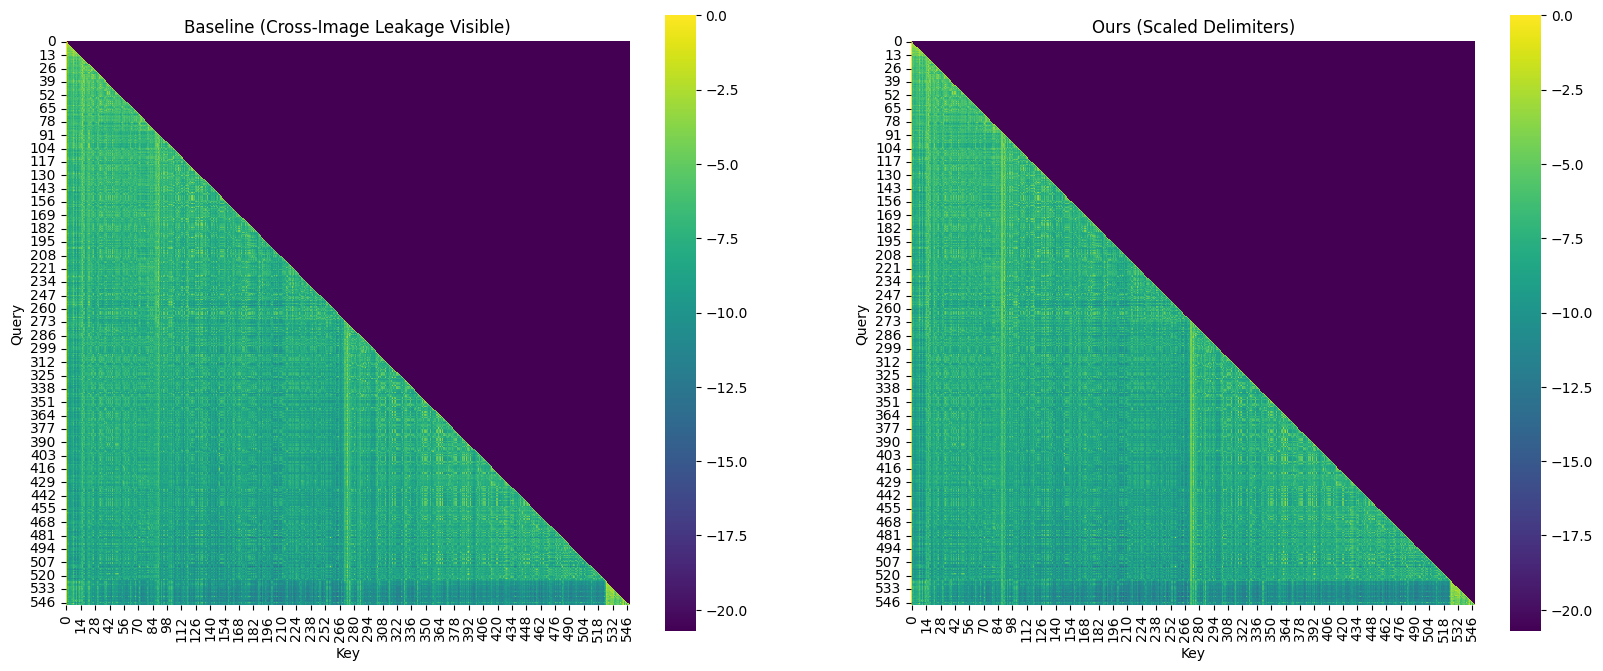

In [ ]:
layer_to_plot = 10
attn_scaled = extract_attention_map(outputs_scaled.attentions, layer_idx=layer_to_plot)
attn_baseline = extract_attention_map(outputs_baseline.attentions, layer_idx=layer_to_plot)
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.heatmap(torch.log(attn_baseline + 1e-9).numpy(), cmap="viridis", square=True)
plt.title("Baseline (Cross-Image Leakage Visible)")
plt.xlabel("Key"); plt.ylabel("Query")

plt.subplot(1, 2, 2)
sns.heatmap(torch.log(attn_scaled + 1e-9).numpy(), cmap="viridis", square=True)
plt.title("Ours (Scaled Delimiters)")
plt.xlabel("Key"); plt.ylabel("Query")

plt.show()

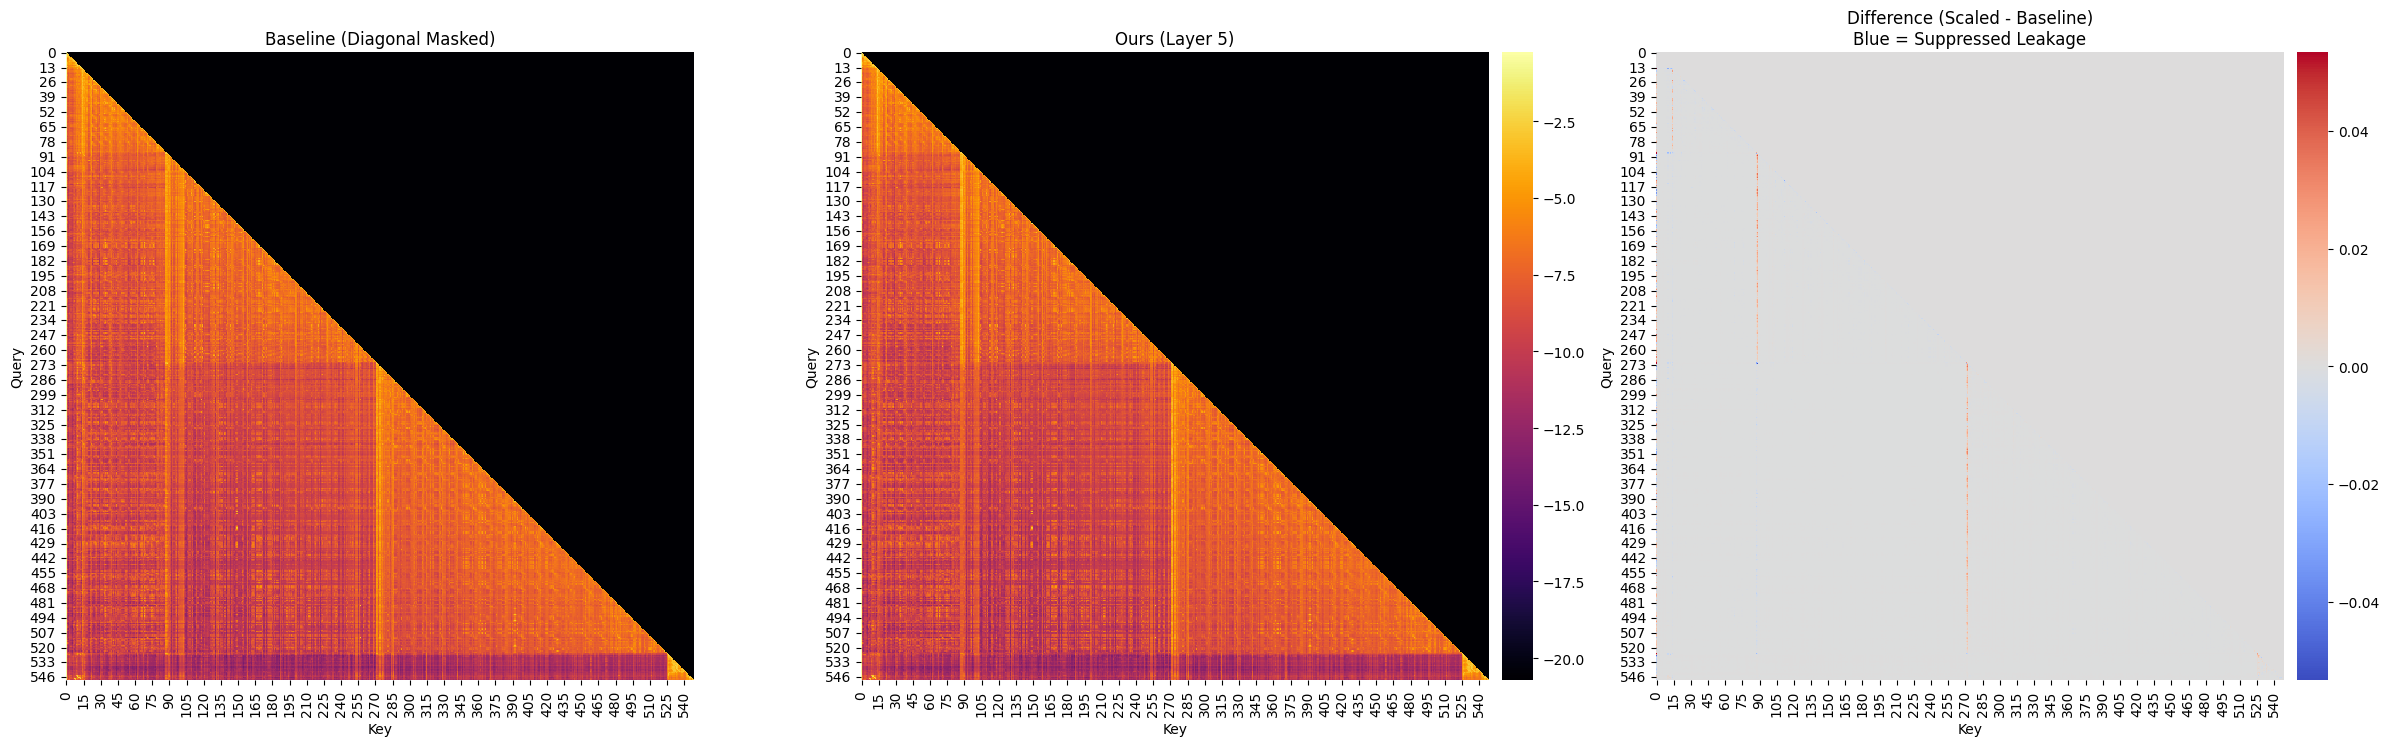

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- DATA PREP (Same as your logic) ---
layer_to_plot = 5
# Assuming outputs_scaled and outputs_baseline exist in your context
attn_scaled = extract_attention_map(outputs_scaled.attentions, layer_idx=layer_to_plot)
attn_baseline = extract_attention_map(outputs_baseline.attentions, layer_idx=layer_to_plot)

attn_baseline_masked = attn_baseline
attn_scaled_masked = attn_scaled

# Log Scale + Shared Color Range
log_baseline = torch.log(attn_baseline_masked + 1e-9).numpy()
log_scaled = torch.log(attn_scaled_masked + 1e-9).numpy()

global_min = min(log_baseline.min(), log_scaled.min())
global_max = max(np.percentile(log_baseline, 99.9), np.percentile(log_scaled, 99.9))

diff = (attn_scaled - attn_baseline).numpy()
limit = np.max(np.abs(diff)) * 0.5 

# --- PLOTTING ---
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Helper function to ensure colorbar matches heatmap height
def add_heatmap(ax, data, title, cmap, vmin, vmax, center=None, add_cbar=True):
    # 1. Create the divider to append an axis to the right
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="2%")
    
    # 2. Plot the heatmap using the 'ax' for plot and 'cax' for colorbar
    sns.heatmap(
        data, 
        ax=ax,
        cmap=cmap, 
        square=True, 
        vmin=vmin, 
        vmax=vmax,
        center=center,
        cbar=add_cbar, # Tell seaborn whether to draw the bar
        cbar_ax=cax if add_cbar else None # Pass the specific axis for the bar
    )
    
    # 3. Handle the "Invisible" Colorbar case
    # If we don't want a colorbar, we still appended the 'cax' to keep the 
    # plot size identical to the others. We just hide the axis.
    if not add_cbar:
        cax.axis('off')

    ax.set_title(title)
    ax.set_xlabel("Key")
    ax.set_ylabel("Query")

# Plot 1: Baseline (No visible colorbar, but space reserved)
add_heatmap(
    axes[0], 
    log_baseline, 
    title="Baseline (Diagonal Masked)", 
    cmap="inferno", 
    vmin=global_min, 
    vmax=global_max, 
    add_cbar=False # Logic hides the cax so sizes stay equal
)

# Plot 2: Scaled (Ours)
add_heatmap(
    axes[1], 
    log_scaled, 
    title=f"Ours (Layer {layer_to_plot})", 
    cmap="inferno", 
    vmin=global_min, 
    vmax=global_max, 
    add_cbar=True
)

# Plot 3: Difference
add_heatmap(
    axes[2], 
    diff, 
    title="Difference (Scaled - Baseline)\nBlue = Suppressed Leakage", 
    cmap="coolwarm", 
    vmin=-limit, 
    vmax=limit, 
    center=0,
    add_cbar=True
)

plt.tight_layout()
plt.show()

In [ ]:
print("--- Baseline Generation ---")
generated_ids = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])

# Generate with Scaling
print("\n--- Ours Generation ---")
scaler.compute_mask(inputs.input_ids)
with scaler:
    with torch.no_grad():
        generated_ids_scaled = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.batch_decode(generated_ids_scaled, skip_special_tokens=True)[0])

--- Baseline Generation ---
system
You are a helpful assistant.
user
Describe the animal in Image 1, Image 2, and Image 3 separately.
assistant
In Image 1, there is a Siamese cat with striking blue eyes and black ears. The cat has a white face with a black mask, black points on its paws, tail, and ears, and a black nose. It appears to be sitting on a carpeted floor.

In Image 2, there is a puppy with a black and white coat. The puppy has a black nose and is sitting on green grass. Its fur is short and fluffy, and it has a collar around its neck.

In Image 3, there is a collie dog with a light brown and white coat. The dog has a black nose and is wearing a collar. The background of the image is a green carpet.

--- Ours Generation ---
All hooks removed.
Hook registered on Layer 0
Hook registered on Layer 1
Hook registered on Layer 2
Hook registered on Layer 3
All hooks removed.
system
You are a helpful assistant.
user
Describe the animal in Image 1, Image 2, and Image 3 separately.
assi